In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD, Adam
import matplotlib .pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet

# 데이터 준비

In [ ]:
# 경로설정
root_dir = "/content"
data_root_dir = os.path.join(root_dir, "COVID-19_Radiography")
train_root_dir = os.path.join(data_root_dir, "train")
test_root_dir = os.path.join(data_root_dir, "test")
val_root_dir = os.path.join(data_root_dir, "val")

In [ ]:
# 데이터 가져오기
from google.colab import drive

drive.mount("/content/drive")

shutil.copy(os.path.join("/content/drive/MyDrive/", "COVID-19_Radiography_Dataset.zip"), root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "COVID-19_Radiography_Dataset.zip")) as target_file:
  target_file.extractall(data_root_dir)

Mounted at /content/drive


In [ ]:
# label(정답) 목록 확인
label_name_list = os.listdir(data_root_dir)
print(label_name_list)

# Train 폴더 생성 및 하위폴더 이동
if not os.path.exists(train_root_dir):
  os.mkdir(train_root_dir)
  print("train 폴더 생성")

for label_name in label_name_list:
  src_root = os.path.join(data_root_dir, label_name)
  dst_root = train_root_dir

  shutil.move(src_root, dst_root)

['Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Normal']
train 폴더 생성


In [ ]:
# Train 데이터 갯수 확인
for label_name in label_name_list:
  print(label_name, len(os.listdir(os.path.join(train_root_dir, label_name))))

Lung_Opacity 6012
Viral Pneumonia 1345
COVID 3616
Normal 10192


In [ ]:
# Test폴더 생성 및 데이터 이동
move_ratio = 0.2

if not os.path.exists(test_root_dir):
  os.mkdir(test_root_dir)

for label_name in label_name_list:
  src_root = os.path.join(train_root_dir, label_name)
  dst_root = os.path.join(test_root_dir, label_name)

  if not os.path.exists(dst_root):
    os.mkdir(dst_root)

  train_file_name_list = os.listdir(src_root)

  np.random.shuffle(train_file_name_list)
  print('shuffle is done')

  split_num = int(len(train_file_name_list) * move_ratio)
  test_file_name_list = train_file_name_list[:split_num]

  move_num = 0
  for test_file_name in test_file_name_list:
    shutil.move(os.path.join(src_root, test_file_name),
                  os.path.join(dst_root, test_file_name))
    move_num += 1
  print(label_name, "total move num : ", move_num)

shuffle is done
Lung_Opacity total move num :  1202
shuffle is done
Viral Pneumonia total move num :  269
shuffle is done
COVID total move num :  723
shuffle is done
Normal total move num :  2038


In [ ]:
# val 폴더 생성 및 데이터 이동
move_ratio = 0.2

if not os.path.exists(val_root_dir):
  os.mkdir(val_root_dir)

for label_name in label_name_list:
  src_root = os.path.join(train_root_dir, label_name)
  dst_root = os.path.join(val_root_dir, label_name)

  if not os.path.exists(dst_root):
    os.mkdir(dst_root)

  train_file_name_list = os.listdir(src_root)

  np.random.shuffle(train_file_name_list)
  print('shuffle is done')

  split_num = int(len(train_file_name_list) * move_ratio)
  val_file_name_list = train_file_name_list[:split_num]

  move_num = 0
  for val_file_name in val_file_name_list:
    shutil.move(os.path.join(src_root, val_file_name),
                  os.path.join(dst_root, val_file_name))
    move_num += 1
  print(label_name, "total move num : ", move_num)

shuffle is done
Lung_Opacity total move num :  962
shuffle is done
Viral Pneumonia total move num :  215
shuffle is done
COVID total move num :  578
shuffle is done
Normal total move num :  1630


In [ ]:
# Train, test, val 데이터 갯수 확인
for label_name in label_name_list:
  print("Train폴더", label_name, len(os.listdir(os.path.join(train_root_dir, label_name))))

print("----------------------------------------------------------------")

for label_name in label_name_list:
  print("Test폴더", label_name, len(os.listdir(os.path.join(test_root_dir, label_name))))

print("----------------------------------------------------------------")

for label_name in label_name_list:
  print("Val폴더", label_name, len(os.listdir(os.path.join(val_root_dir, label_name))))

Train폴더 Lung_Opacity 3848
Train폴더 Viral Pneumonia 861
Train폴더 COVID 2315
Train폴더 Normal 6524
----------------------------------------------------------------
Test폴더 Lung_Opacity 1202
Test폴더 Viral Pneumonia 269
Test폴더 COVID 723
Test폴더 Normal 2038
----------------------------------------------------------------
Val폴더 Lung_Opacity 962
Val폴더 Viral Pneumonia 215
Val폴더 COVID 578
Val폴더 Normal 1630


In [ ]:
img_width = 224
img_height = 224

# Project-1
- TL : Mobilenet
- FC계층
  - hidden layer 0
  - Drop out 0
  - optimizer : Adam(1e-4)
  - epochs : 30

In [ ]:
# ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale = 1./255)

train_gen = train_data_gen.flow_from_directory(directory = train_root_dir,
                                   batch_size = 32,
                                   target_size = (img_height, img_width),
                                   class_mode = "sparse")

val_gen = val_data_gen.flow_from_directory(directory = val_root_dir,
                                   batch_size = 32,
                                   target_size = (img_height, img_width),
                                   class_mode = "sparse")

test_gen = test_data_gen.flow_from_directory(directory = test_root_dir,
                                             batch_size = 32,
                                   target_size = (img_height, img_width),
                                   class_mode = "sparse")


Found 13548 images belonging to 4 classes.
Found 3385 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [ ]:
train_gen.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
# model 구축
base_model = MobileNet(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-4),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 30, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

[0.7634183764457703, 0.9359641075134277]

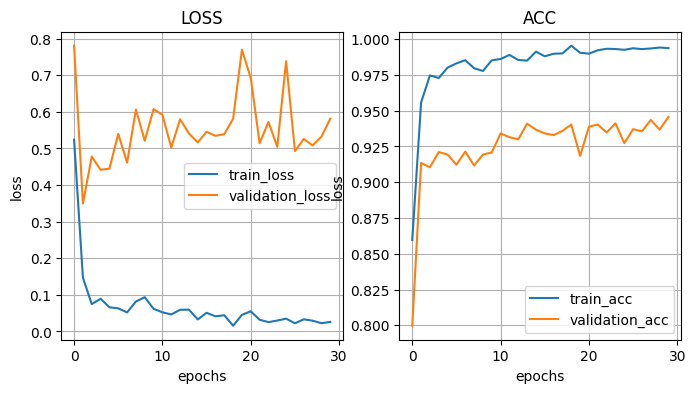

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-1 / Mobilenet
- TL : Mobilenet
- FC계층
  - hidden layer 3 / node : 128
  - Drop out 0.25
  - optimizer : Adam(1e-5)
  - epochs : 30

In [ ]:
# model 구축
base_model = MobileNet(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 30, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

[0.5023084878921509, 0.9246219396591187]

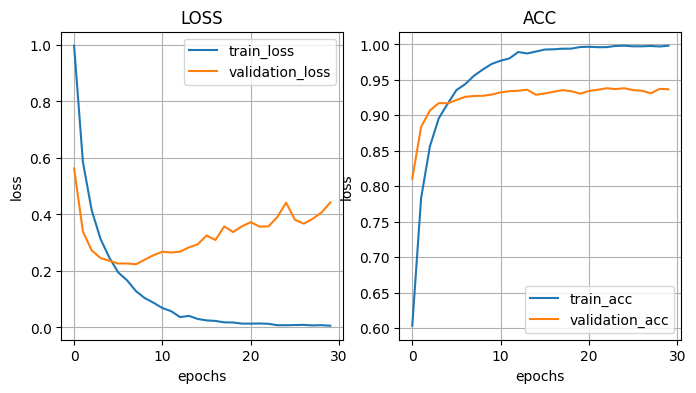

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-1 / Mobilenet
- TL : Mobilenet
- FC계층
  - hidden layer 3 / node : 128
  - Drop out 0.5
  - optimizer : Adam(1e-5)
  - epochs : 35

In [ ]:
# model 구축
base_model = MobileNet(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 35, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

[0.5867437720298767, 0.9279300570487976]

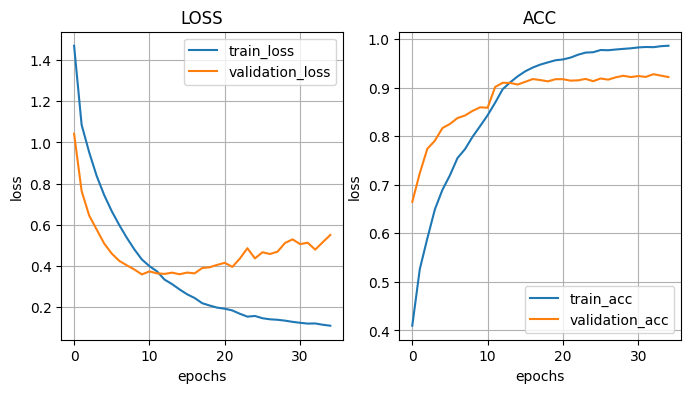

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-2 / Xception
- TL : Xception
- FC계층
  - hidden layer 0
  - Drop out 0
  - optimizer : Adam(1e-4)
  - epochs : 30

In [ ]:
# model 구축
base_model = Xception(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 30, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

[0.500329852104187, 0.9232041835784912]

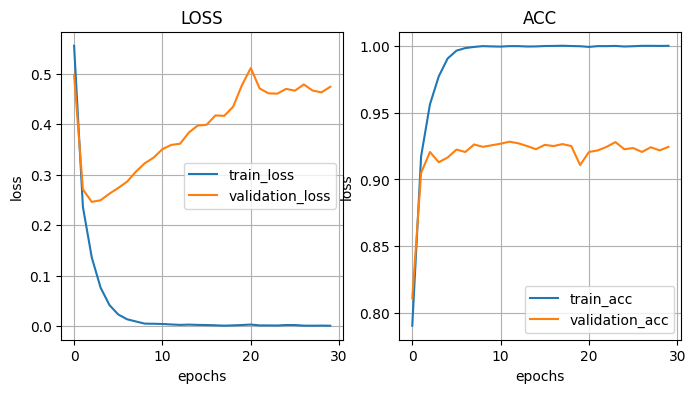

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-2 / Xception
- TL : Xception
- FC계층
  - hidden layer 3 / node : 128
  - Drop out 0.25
  - optimizer : Adam(1e-4)
  - epochs : 20

In [ ]:
# model 구축
base_model = Xception(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

[0.6267958879470825, 0.929347813129425]

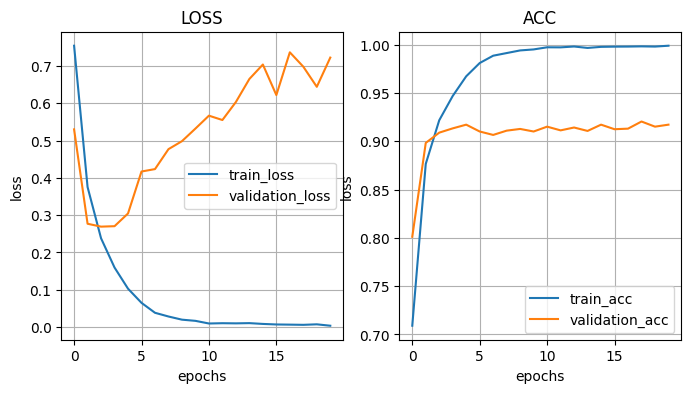

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-2 / Xception
- TL : Xception
- FC계층
  - hidden layer 3 / node : 128
  - Drop out 0.5
  - optimizer : Adam(1e-4)
  - epochs : 20

In [ ]:
# model 구축
base_model = Xception(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

[0.7406393885612488, 0.9229678511619568]

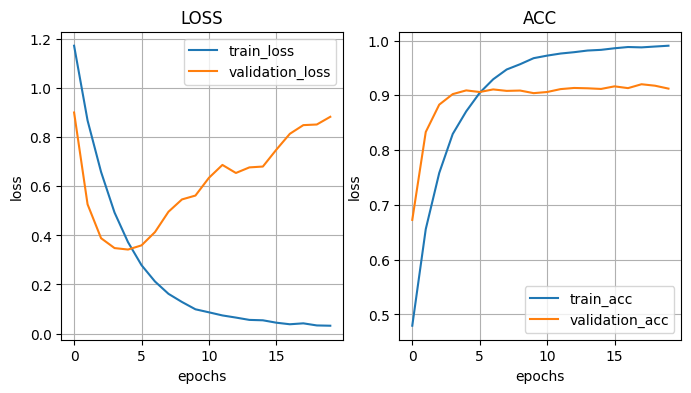

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-2 / Xception
- TL : Xception
- FC계층
  - hidden layer 3 / node : 128
  - Drop out 0.6
  - optimizer : Adam(1e-4)
  - epochs : 20

In [ ]:
# model 구축
base_model = Xception(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.6))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.6))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.6))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(2e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

[0.801712691783905, 0.9229678511619568]

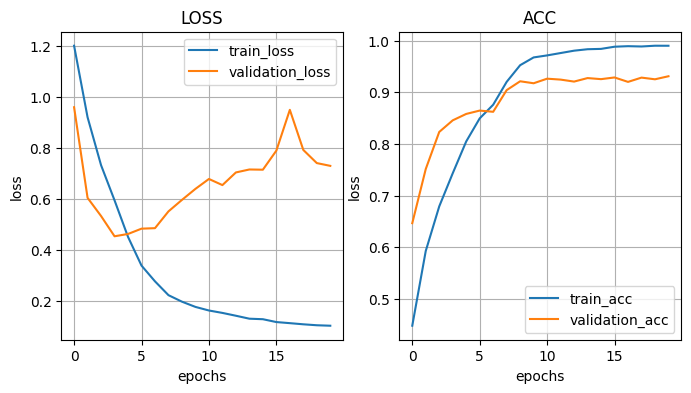

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-3 / Resnet50
- TL : Resnet50
- FC계층
  - hidden layer 0
  - Drop out 0
  - optimizer : Adam(1e-4)
  - epochs : 20

In [ ]:
# model 구축
base_model = ResNet50(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-4),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

[0.4853784441947937, 0.9262759685516357]

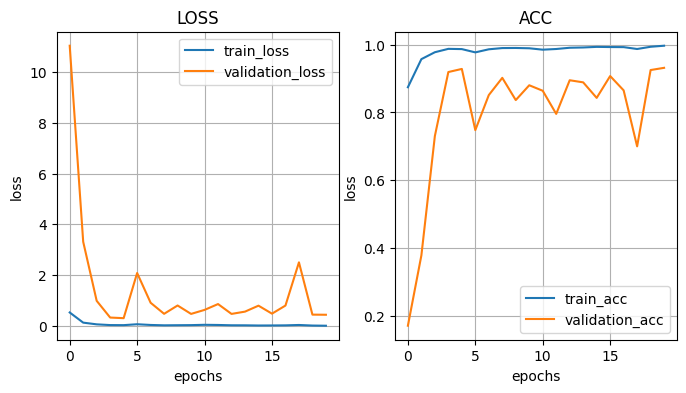

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-3 / Resnet50
- TL : Resnet50
- FC계층
  - hidden layer 3 / node : 128
  - Drop out 0.25
  - optimizer : Adam(1e-5)
  - epochs : 20

In [ ]:
# model 구축
base_model = ResNet50(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(1e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

[0.660515546798706, 0.9260396957397461]

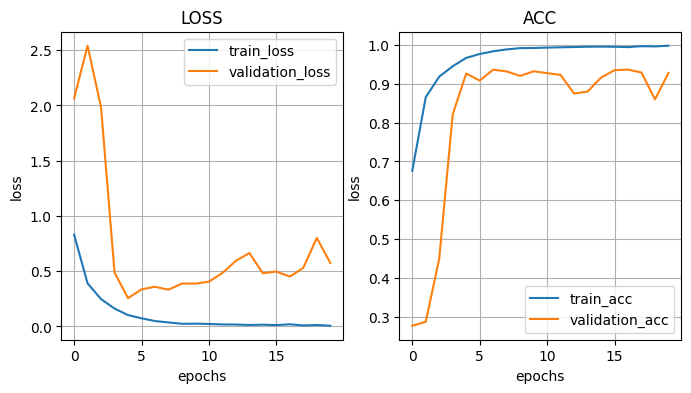

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

## Project-3 / Resnet50
- TL : Resnet50
- FC계층
  - hidden layer 3 / node : 128
  - Drop out 0.45
  - optimizer : Adam(2e-5)
  - epochs : 20

In [ ]:
# model 구축
base_model = ResNet50(weights = "imagenet", include_top=False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.45))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.45))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.45))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(2e-5),
              metrics = "acc")
model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)
print("---------------------------------------")
model.evaluate(test_gen)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")